In [28]:
from scipy.optimize import minimize
import control
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [29]:
# This if else is a fix to make the file available for Jupyter and Travis CI
import os


def find_csv(filename):
    if os.path.isfile(filename):
        file = filename
    else:
        file = '04_mini-projects/' + filename
    return file

In [30]:
wheel_ang = np.genfromtxt(find_csv('wheel_angle.csv'), delimiter=",")
beta = np.genfromtxt(find_csv('beta.csv'), delimiter=",")
psi = np.genfromtxt(find_csv('psi.csv'), delimiter=",")

In [31]:
def plot_input_and_states(psi, beta, title):
    plt.figure()
    plt.plot(wheel_ang[1])
    plt.plot(psi)
    plt.plot(beta)
    plt.legend(
        ["Wheel angle in rad", r"$\dot{\psi}$ in rad per second", r"$\beta$ in rad", ])
    plt.xlabel("time in 1/100 seconds")
    plt.title(title)
    plt.show()

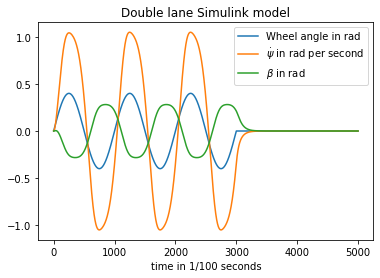

In [32]:
plot_input_and_states(psi=psi[1], beta=beta[1],
                      title="Double lane Simulink model")

In [33]:
def single_track_model(c_f, c_r, l_f, l_r, m, theta, v):
    """
    Vehicle single track model from [p. 230, Schramm2018]
    states = [\dot{psi} in rad/s\\
              beta in rad]
    Args:
        c_f: Front cornering stiffness [N/rad]
        c_r: Rear cornering stiffness [N/rad]
        l_f: Distance CoG to front axles [m]
        l_r: Distance CoG to rear axles [m]
        m: Vehicle mass [kg]
        theta: Vehicle yaw inertia [kgm^2]
        v: Vehicle Speed [m/s]

    Returns:
        state space model
    """
    a_11 = -1 / v * (c_f * l_f ** 2 + c_r * l_r ** 2) / theta
    a_12 = -(c_f * l_f - c_r * l_r) / theta
    a_21 = -1 - 1 / (v ** 2) * (c_f * l_f - c_r * l_r) / m
    a_22 = -1 / v * (c_f + c_r) / m
    a_matrix = np.array([[a_11, a_12], [a_21, a_22]])

    b_1 = (c_f * l_f) / theta
    b_2 = 1 / v * c_f / m
    b_matrix = np.array([[b_1], [b_2]])

    c_matrix = np.array([[1, 0], [0, 1]])
    d_matrix = np.array([[0], [0]])

    return control.ss(a_matrix, b_matrix, c_matrix, d_matrix)

In [34]:
ss_model = single_track_model(
    c_f=12e3, c_r=11e3, l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

y, x = control.forced_response(
    ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

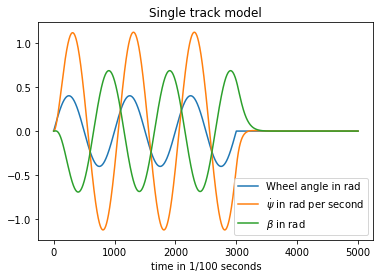

In [35]:
plot_input_and_states(psi=y[0], beta=y[1], title="Single track model")

In [36]:
def validation_plot(y_single_track_model):
    plt.figure()
    plt.plot(psi[1])
    plt.plot(y_single_track_model[0])
    plt.plot(beta[1])
    plt.plot(y_single_track_model[1])
    plt.legend([r"$\dot{\psi}$ reference", r"$\dot{\psi}$ model",
                r"$\beta$ reference", r"$\beta$ model"])
    plt.show()

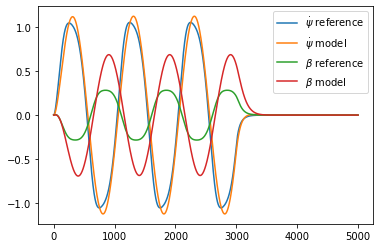

In [37]:
validation_plot(y)

In [38]:
def error(y_single_track_model):
    err0 = psi[1] - y_single_track_model[0]
    err1 = beta[1] - y_single_track_model[1]

    scaled_err0 = (err0 - np.min(err0)) / (np.max(err0) - np.min(err0))
    scaled_err1 = (err1 - np.min(err1)) / (np.max(err1) - np.min(err1))
    
    print(np.sum(scaled_err0 ** 2))
    print(np.sum(scaled_err1 ** 2))
    
    return np.sum(scaled_err0 ** 2) + np.sum(scaled_err1 ** 2)

In [39]:
error(y)

1480.8804164893545
1601.1354468732284


3082.015863362583

In [40]:
def objective_func(x):
    ss_model = single_track_model(
        c_f=x[0], c_r=x[1], l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

    y, x = control.forced_response(
        ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

    return error(y)

In [41]:
def parameter_fitting():
    x0 = np.array([11e3, 11e3])
    res = minimize(fun=objective_func, x0=x0,
                   method='Powell', options={'disp': True})
    print("Optimized params")
    print(res.x)
    return res.x

In [42]:
optimized_params = parameter_fitting()

1263.4883726227015
1596.4290481320622
1263.4883726227015
1596.4290481320622
1263.4243664606142
1596.4548164063985
1263.3223617230265
1596.4965305757346
1260.9554953337845
1597.8321711880662
1259.8841161598098
1599.9549970610456
1260.9554953337845
1597.8321711880662
1260.1294595364125
1598.6503194253446
1259.911568017837
1599.1530031449574
1260.460883096529
1598.2557379516643
1260.4421124205244
1598.2736837164196
1260.4083176238532
1598.3065397437176
1260.2808185626673
1598.4376604211002
1260.382749874225
1598.3318885871383
1260.3641443169831
1598.3506152381296
1260.382749874225
1598.3318885871383
1260.4132302948772
1598.293043924901
1260.463784785313
1598.2302576497418
1260.866360186639
1597.7722012153658
1261.7042693588705
1597.0223855417328
1260.866360186639
1597.7722012153658
1261.1528848202674
1597.4820545904226
1261.3441696876905
1597.303503526615
1261.0409217464785
1597.5918511895031
1261.0333694736719
1597.5994128649245
1261.0484933994896
1597.584290562926
1259.960806278142
1598

In [43]:
ss_model = single_track_model(
    c_f=11130, c_r=11054, l_f=1.4, l_r=1.6, m=2000, theta=4000, v=10)

y, x = control.forced_response(
    ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

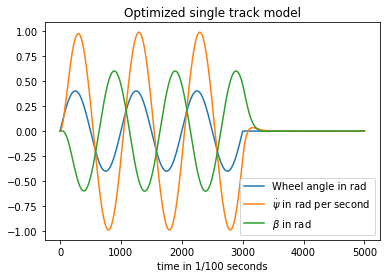

In [44]:
plot_input_and_states(psi=y[0], beta=y[1],
                      title="Optimized single track model")

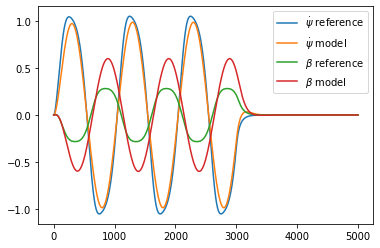

In [45]:
validation_plot(y)

In [46]:
error(y)

1260.4201636325815
1597.8121983391713


2858.2323619717527

### Further optimization attempts

In [47]:
def objective_func_ext(x):
    ss_model = single_track_model(
        c_f=x[0], c_r=x[1], l_f=1.4, l_r=1.6, m=2000, theta=x[2], v=10)

    y, x = control.forced_response(
        ss_model, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

    return error(y)

In [48]:
def parameter_fitting_ext():
    x0 = np.array([11e3, 11e3, 4000])
    res = minimize(fun=objective_func_ext, x0=x0,
                   method='Powell', options={'disp': True})
    print("Optimized params")
    print(res.x)
    return res.x

In [49]:
for i in range(len(beta[1] - y[1])):
    print((beta[1] - y[1])[i])

0.0
-6.806933666064467e-06
3.6132125947572086e-06
2.9508706810285508e-05
6.922111699817332e-05
0.00012120639156327381
0.00018395765854110953
0.0002561148769017292
0.00033635587834090856
0.00042343955488711744
0.0005162330346607557
0.0006136195992609031
0.0007146344197995742
0.0008182547283150748
0.000923637132897537
0.0010300153763575046
0.0011365035033128262
0.0012425015830688643
0.0013471873003853905
0.00145011956384798
0.001550643775709648
0.0016482811555890713
0.0017425376059484123
0.0018330035594145036
0.0019192488577784834
0.002001025896930242
0.0020778726193131534
0.0021495125012206363
0.0022158492736982192
0.002276570207527289
0.0023315462392929
0.0023805351005731887
0.0024234811439271193
0.00246021020066397
0.0024906327046525225
0.0025148466637569702
0.002532634917857608
0.002544062840717629
0.0025490841589398965
0.0025478409085310156
0.0025402608336292983
0.0025264522226479194
0.002506410161427928
0.0024803381391523046
0.0024483137329098974
0.0024104746936231738
0.00236677480

-0.008484263200091352
-0.00673073969963453
-0.004963669511063917
-0.003183220919561275
-0.0013995330685482033
0.00039725400598755733
0.0022070008958432474
0.004019567359183851
0.005844813839556567
0.007682600003156931
0.009522786256546789
0.011375232282644143
0.013239771473534168
0.015116266566534614
0.016994606688414043
0.018884651769407096
0.02078626263152944
0.022699299520954036
0.024613596537266275
0.02654904434967778
0.02848550305283687
0.030422808149790093
0.032380850285472634
0.03433949108201148
0.03630859322266508
0.03828801897989553
0.04027763172403795
0.04227729445038497
0.04427687128688498
0.0462862260202721
0.04830522360282516
0.05033372867757396
0.05236160708415072
0.054408751466753724
0.056455025677808274
0.05851026777244264
0.06056437271580184
0.0626372052301008
0.06470860576897103
0.0667884702424762
0.06887669292772813
0.07096311235966496
0.07305759850704502
0.07516004682038568
0.0772703256121337
0.07938830314918549
0.0815038220682491
0.08362678207839216
0.0857470798870

-0.24785984415485893
-0.24668344197260986
-0.2455091144482652
-0.24432695974833107
-0.24313707607922366
-0.24194956293139622
-0.24075451817491042
-0.23956204116412677
-0.23836223509804844
-0.2371652015593113
-0.23596104061509804
-0.23474985377165583
-0.23354174648259882
-0.23233682524613056
-0.2311151921438255
-0.22990695350888704
-0.2286822165741782
-0.22746108445617091
-0.2262436670824419
-0.22502007257480355
-0.2237904076480214
-0.22256478297429516
-0.2213433102792618
-0.22010609958794794
-0.21888325947336537
-0.2176449025689988
-0.2164111425147256
-0.21518209405917793
-0.21394787015652575
-0.21270858236401757
-0.21147434620531164
-0.21023527826535277
-0.2089914934352252
-0.20775310786803586
-0.2065202414885847
-0.20527301238359136
-0.20403153705197763
-0.20279593321066391
-0.20155632516064456
-0.2003128377337624
-0.19907557488444783
-0.19783465420054852
-0.19659022101055193
-0.19535239271769445
-0.19411126172634435
-0.19286697808266162
-0.19162966225641534
-0.19038943813514103
-0.1

-0.20154865473204614
-0.2035142317925605
-0.20547102728586103
-0.20741894863129856
-0.20934790502855227
-0.21127780596013146
-0.2131885626749414
-0.21509008669072338
-0.216972291277563
-0.21885508996027725
-0.2207183980018722
-0.22257215798953456
-0.22440625713308515
-0.22623061442326853
-0.22804517466233482
-0.22984982874354637
-0.23163449782833495
-0.23340910327429698
-0.23516356811854028
-0.2369078426635769
-0.2386418488593423
-0.24035548327645123
-0.2420586727090583
-0.24374134410283088
-0.24541342603828376
-0.24706484723301847
-0.24870553802505974
-0.25033542887509985
-0.25194445184984293
-0.2535325391242591
-0.25510959738129135
-0.2566755634154382
-0.2582104011451022
-0.25974404599534295
-0.26125640787187426
-0.2627474267646757
-0.2642270426767268
-0.2656851700244594
-0.26713175324208666
-0.26855676379469917
-0.26996014456176365
-0.271351812811868
-0.2727216887234298
-0.2740797224154891
-0.27541589096153296
-0.276730142773719
-0.2780324005783432
-0.27931258993726904
-0.2805806662

0.00020331731620308927
0.0001994589280362767
0.00019565384036836735
0.00019190156573838075
0.00018820261884951872
0.0001845545166102592
0.00018095877817407487
0.00017741392497780067
0.0001739184807786746
0.00017047397169007587
0.00016707792621598405
0.00016373087528418235
0.00016043235227822855
0.0001571808930682157
0.00015397703604034564
0.00015082032212533693
0.0001477092948256895
0.0001446445002418272
0.00014162348709713973
0.0001386488067619449
0.00013571701327639167
0.00013282966337232468
0.00012998531649413035
0.00012718353481858398
0.00012442488327371804
0.00012170692955673045
0.00011903124415095217
0.00011639540034189265
0.00011379997423238176
0.00011124454475682647
0.00010872869369460011
0.00010625200568258203
0.00010381406822686512
0.00010141347171364837
9.905080941933147e-05
9.67256775198282e-05
9.44366750991149e-05
9.218440415703067e-05
8.996846961634474e-05
8.778747932910723e-05
8.564104408229873e-05
8.352977760279382e-05
8.145229656165381e-05
7.940922057776342e-05
7.73981

5.66917921463546e-09
5.5572794729029225e-09
5.446945787860331e-09
5.338162547250176e-09
5.230914212645318e-09
5.1251843206588445e-09
5.020957484111529e-09
4.918219393157651e-09
4.816953816369924e-09
4.717144601784315e-09
4.6187786779054546e-09
4.5218390546733925e-09
4.426310824392418e-09
4.332180162622641e-09
4.2394313290350504e-09
4.148049668230729e-09
4.058021610524919e-09
3.969330672696592e-09
3.881962458704213e-09
3.795903660368329e-09
3.7111400580216366e-09
3.627656521127174e-09
3.545439008865247e-09
3.4644745706897222e-09
3.3847473468542945e-09
3.3062445689093196e-09
3.228952560169827e-09
3.1528567361552746e-09
3.0779446050016336e-09
3.004201767846375e-09
2.931615919186905e-09
2.860172847213014e-09
2.789858434113879e-09
2.720661656360148e-09
2.6525685849616476e-09
2.5855653857012256e-09
2.519641319345242e-09
2.454780741831219e-09
2.390974104433143e-09
2.3282059539049072e-09
2.266465932602386e-09
2.205740778584611e-09
2.146018325694514e-09
2.087287503619711e-09
2.029534337933767e-

In [50]:
optimized_params_ext = parameter_fitting_ext()

1263.4883726227015
1596.4290481320622
1263.4883726227015
1596.4290481320622
1263.4243664606142
1596.4548164063985
1263.3223617230265
1596.4965305757346
1260.9554953337845
1597.8321711880662
1259.8841161598098
1599.9549970610456
1260.9554953337845
1597.8321711880662
1260.1294595364125
1598.6503194253446
1259.911568017837
1599.1530031449574
1260.460883096529
1598.2557379516643
1260.4421124205244
1598.2736837164196
1260.4083176238532
1598.3065397437176
1260.2808185626673
1598.4376604211002
1260.382749874225
1598.3318885871383
1260.3641443169831
1598.3506152381296
1260.382749874225
1598.3318885871383
1260.4132302948772
1598.293043924901
1260.463784785313
1598.2302576497418
1260.866360186639
1597.7722012153658
1261.7042693588705
1597.0223855417328
1260.866360186639
1597.7722012153658
1261.1528848202674
1597.4820545904226
1261.3441696876905
1597.303503526615
1261.0409217464785
1597.5918511895031
1261.0333694736719
1597.5994128649245
1261.0484933994896
1597.584290562926
1261.0409217464785
159

1203.7413493488434
1590.849005969868
1149.2617146296575
1589.6857423392114
1158.3136056360559
1592.5366397118082
1180.9577554875038
1587.7120972415537
1148.8067949634851
1590.80135884077
1148.6153530849365
1590.0261940366922
1148.5483794664083
1590.08355553899
1148.5307099228844
1590.1012605837723
1148.5398155959494
1590.09196152896
1148.543947872302
1590.0878666161068
1148.5357576423821
1590.0960571093892
1148.5398155959494
1590.09196152896
1148.6286229548652
1590.0864381409265
1148.4009329669166
1590.1008433009808
1147.0095510881874
1590.265535806794
1152.1573686038582
1590.4022993267722
1147.0095510881874
1590.265535806794
1147.9176635486824
1590.3275237460934
1147.1670907002733
1590.2113618340575
1147.0025976177571
1590.249400167284
1147.000670442706
1590.2506931387027
1146.9989914356852
1590.2519960781733
1146.994957490062
1590.2572069060047
1146.9975686957728
1590.253309023831
1146.996410523453
1590.2546320128924
1146.9975686957728
1590.253309023831
1145.9747566997949
1590.103845

779.4902405617172
1584.743396137136
774.9880107796945
1587.1444077674678
775.9729354707215
1586.1723251474396
774.932554427928
1586.6528535050033
774.6020041668198
1586.8182268078403
774.7045245746251
1586.7608716077048
774.6374040919505
1586.7929297771989
774.6077095917974
1586.807150975692
774.5979137742033
1586.8118475486074
774.5982691512213
1586.814862842587
774.5960092488558
1586.8128276300522
774.5965903795327
1586.8124822435238
774.5962012154575
1586.8126688940238
774.5960248848521
1586.8127534669013
774.5959667401037
1586.81278135486
774.5959794788229
1586.8128008207825
774.5959681076585
1586.812790580563
774.5959610659584
1586.8127842392473
774.5959627835026
1586.812783252576
774.5959615120952
1586.8127838623686
774.5959610866516
1586.8127840664183
774.5959610450382
1586.8127840863929
774.5959609779545
1586.8127841185706
774.5959609831739
1586.8127841646608
774.595960971204
1586.8127841217952
774.5959609537488
1586.8127841381684
774.5959609528086
1586.8127841306084
774.595960

In [51]:
ss_model_ext = single_track_model(
    c_f=4191, c_r=3949, l_f=1.4, l_r=1.6, m=2000, theta=1682, v=10)

y, x = control.forced_response(
    ss_model_ext, T=wheel_ang[0], U=wheel_ang[1], X0=np.array([0, 0]))[1:3]

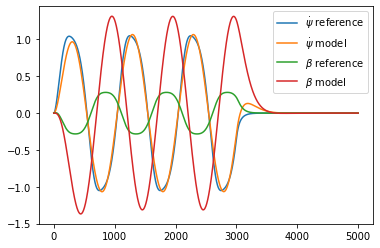

In [52]:
validation_plot(y)

In [53]:
error(y)

775.0934357543215
1586.6400044470947


2361.733440201416

### Custom (randomized) Optimizer

In [54]:
range_calibration_parameters = np.array([[0, 10000], [0, 10000], [0, 10000]]) # order: c_f, c_r, theta
cut_off_cost = 2000

best_cost = 10e10
best_params = [11e3, 11e3, 4000]

for i in range(0, 1000):
    if(i % 100 == 0):
        print("Current iteration:", str(i))
    random_params = [np.random.uniform(range_calibration_parameters[i, 0],
                                       range_calibration_parameters[i, 1])
                     for i in range(range_calibration_parameters.shape[0])]
    current_cost = objective_func_ext(random_params)

    if current_cost < best_cost:
        best_cost = current_cost
        best_params = random_params
        print("****Iteration", str(i), "****")
        print("New best cost:", best_cost)
        print("New best params:", best_params)

print("****Final Result****")
print(best_cost)
print(best_params)

Current iteration: 0
1520.6913058651426
1586.810116744411
****Iteration 0 ****
New best cost: 3107.5014226095536
New best params: [5255.008535517392, 7143.541715776346, 9810.873031126635]
1658.0962677232033
2012.5583469724793
4589.659927430432
137.44727665312647
4817.1566695274
61.61580704526982
1617.8557650817327
1593.5613111826706
1750.7857807852579
1779.0801268898174
1674.7187488093673
1724.7795750289788
1664.3271514536013
1594.2103822154734
1526.2821489841094
1603.8301165159457
1681.2789286032828
1718.396987361627
2739.2094594081373
776.661677372165
1742.0777352236496
1549.3850180722598
4850.446157960436
50.519613401284204
1679.8452638913795
1714.1226527648982
1681.8265547153069
1714.0422252436836
1839.8056266507879
1358.9491046523297
4733.929175300761
89.35787939817729
4476.4963178362505
175.15972072936648
1542.521331602362
1611.6501999351972
1675.9009050108916
1708.5214065244245
2108.4863982415636
1195.8963548765146
1603.062233680042
1641.1160878231005
1626.9471815262918
1538.708

4923.0325048790255
26.32572543281614
2838.957812691244
630.3339792719624
4805.100281748344
65.63451883959705
1520.159291373148
1598.3359672709516
4948.339931366339
17.891482152763732
4277.859125123889
241.30035702473208
4839.0488329048785
54.31860414305998
1479.6293611499545
1614.035092051714
1600.439905271339
1591.456547389571
4473.915982927015
176.02666820257528
3289.0281292615664
549.7479299673541
1636.9344624814785
1899.254005634768
1997.3022371847214
1048.500647505004
1556.0647851995388
1605.6345798850448
1693.8992847261275
1654.0424938411616
1534.9733607253615
1260.9367015012597
3590.398187764465
456.90882404803955
1674.6602169561465
1584.3234690394816
2638.865548044422
1133.8355443617634
3953.3897484247223
347.7119741211118
1597.0309322440291
1645.151786290282
1642.389927241937
1360.8056239197988
4680.329548288801
107.22426387793841
1556.5332185754314
1588.8848758452948
1709.1088754643092
1565.9651230816523
1678.1877553062773
1717.2449925221727
4848.607732349233
51.1324017736145

1551.9045705677
1626.617516094099
1708.581718278342
1642.66545987903
1576.6780523808834
1560.562798484437
1617.6428647440343
1829.6139242266754
1704.0126686732663
1966.9909973050878
1475.7007401632607
1575.0101205483902
4828.458873023966
57.848495457050554
1689.7081694568249
1958.1928481143368
1716.6264773413513
1463.0830723121169
1695.421353010648
1685.0431947245302
1706.361349466159
1735.2907904007916
1631.6290394670068
1523.9105285965231
1671.0134653105235
1832.9364988299249
1547.1302007892018
1543.4049159128367
1690.5064301811974
1732.928121278379
3758.336555013431
414.4872365162818
1705.980927891906
1527.3100684735182
1519.1021748492267
1552.6476236650897
1472.2791434110266
1553.4986570299857
1691.2464320697368
2163.203706380774
1680.7826977747534
1800.5918758638627
4471.047773494935
176.98203521117009
1709.8561053613714
1590.4935982082045
1679.1068959823792
1972.8648728790847
4679.063916237688
107.6461386422154
1718.806348625269
1508.3679677064022
1505.5343277942404
1565.84762505

1545.4083747756438
4757.652949240686
81.45004637062398
4776.339249720779
75.22136535997878
4743.475445277751
86.17582423971466
4529.034863787058
157.65410079618132
1707.827899504202
1593.9541628627264
1810.9839077594459
1082.7905625807507
4810.514818545675
63.8297097033761
1527.7112162405706
1590.7023167507336
1497.3879616915829
1683.4924210185723
4824.901531945252
59.03424637888432
1691.495023605564
1732.2033201344452
1370.3136681943186
1639.9805729043892
1589.8547014799292
1586.8415161002501
1708.3196604568889
1535.2006518903145
1484.3617506239352
1560.8391366230312
1706.2928467403963
1923.1825617275447
1735.2498970201032
1521.5040909772042
1731.3694421748396
1564.6663455650032
4750.286112971742
83.90562814944377
4800.020109130551
67.32787729186018
1653.6473470578946
1583.2631972344298
1619.4138389725317
1566.8934629872265
4894.094705802895
35.970780867281746
2571.1423311850053
1062.0864083870908
1614.2945000276732
2074.6222058909925
1668.6979018084512
1566.6843426093028
1726.2081917

1539.0362302658355
1667.5498492527759
1417.907607436059
1652.4173411369877
4735.62516488582
88.79255554422448
4882.494051923841
39.83743453413951
1697.335864032744
1983.6683411525892
4802.378797167076
66.54166279211746
1699.5327250860641
1731.113198376041
1688.9333341465372
1713.3938495457746
1678.033646197673
1710.5394513235065
4620.932544281837
127.0230924410844
1720.9310493270655
2204.6092521136484
4766.097170331468
78.6353430925135
1495.047020754561
1676.2612327813395
1567.6083562623253
1529.7279500024617
1698.7466916459164
1614.8133262554516
1697.1217693445428
1709.7564865124812
Current iteration: 900
1688.4038051630082
1717.7552690929824
1672.668612727557
1878.205659829684
1355.7897663992335
1655.66130101527
1339.479749258824
1647.2977181223305
1449.2653497436488
1524.7231081114305
1530.8237505081995
1651.4284132310288
2495.495402595874
1071.047930441836
4467.602818502539
178.1291938547013
4808.059008670019
64.64829620293933
4773.560379473959
76.14764178589598
4524.689441129667
1